In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/GRU/Test

/content/drive/MyDrive/GRU/Test


In [ ]:
!pip install tensorflow


In [ ]:
!pip install keras

# Tien Xu Ly


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def process_data(train, test, lags):
    """Process data
    Reshape and split train\test data.

    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    attr = 'Vehicles'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    # scaler = StandardScaler().fit(df1[attr].values)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

# Model

In [ ]:
from keras.layers import Dense, Dropout, Activation, LSTM, GRU
from keras.models import Sequential


def get_lstm(units):
    """LSTM(Long Short-Term Memory)
    Build LSTM Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(LSTM(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(LSTM(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model


def get_gru(units):
    """GRU(Gated Recurrent Unit)
    Build GRU Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model



# Train

In [ ]:
import sys
import warnings
import argparse
import numpy as np
import pandas as pd
from keras.models import Model
from keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")


def train_model(model, X_train, y_train, name, config):
    """train
    train a single model.

    # Arguments
        model: Model, NN model to train.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        validation_split=0.05)

    model.save('/content/drive/MyDrive/GRU/Test/Model/' + name + '.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('/content/drive/MyDrive/GRU/Test/Model/' + name + ' loss.csv', encoding='utf-8', index=False)




In [ ]:
def main(argv):
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--model",
        default="lstm",
        help="Model to train.")
    args = parser.parse_args()

    lag = 12
    config = {"batch": 256, "epochs": 600}
    file1 = 'data/train_data.csv'
    file2 = 'data/test_data.csv'
    X_train, y_train, _, _, _ = process_data(file1, file2, lag)

    if args.model == 'lstm':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        m = model.get_lstm([12, 64, 64, 1])
        train_model(m, X_train, y_train, args.model, config)
    if args.model == 'gru':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        m = model.get_gru([12, 64, 64, 1])
        train_model(m, X_train, y_train, args.model, config)
    if args.model == 'saes':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
        m = model.get_saes([12, 400, 400, 400, 1])
        train_seas(m, X_train, y_train, args.model, config)


if __name__ == '__main__':
    main(sys.argv)

Train GRU

In [ ]:
lag = 12
config = {"batch": 128, "epochs": 50}
file1 = '/content/drive/MyDrive/GRU/Test/Model/Data/train.csv'
file2 = '/content/drive/MyDrive/GRU/Test/Model/Data/test.csv'
X_train, y_train, _, _, _ = process_data(file1, file2, lag)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
m = get_gru([12, 64, 64, 1])
train_model(m, X_train, y_train, "gru_manual_run", config)

Epoch 1/50
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0587 - mape: 16659565.0000 - val_loss: 0.0600 - val_mape: 15503279.0000
Epoch 2/50
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0581 - mape: 16761372.0000 - val_loss: 0.0596 - val_mape: 16630287.0000
Epoch 3/50
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0580 - mape: 16603714.0000 - val_loss: 0.0598 - val_mape: 15996886.0000
Epoch 4/50
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0577 - mape: 16602291.0000 - val_loss: 0.0596 - val_mape: 16407803.0000
Epoch 5/50
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0581 - mape: 16587475.0000 - val_loss: 0.0597 - val_mape: 16036766.0000
Epoch 6/50
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0580 - mape: 16441642.0000 - val_loss: 0.0596 - val_mape: 16609358.0000
Epoch 7/50
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0574 - mape: 16579368.0000 - val_loss: 0.0596 - val_mape: 16470000.0000
Epoch 8/50
3121/3121 ━━━━━━━━━━━━━━━━━━━━

Train LSTM

In [ ]:
lag = 12
config = {"batch": 64, "epochs": 100}
file1 = '/content/drive/MyDrive/GRU/Test/Data/train_data.csv'
file2 = '/content/drive/MyDrive/GRU/Test/Data/test_data.csv'
X_train, y_train, _, _, _ = process_data(file1, file2, lag)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
m = get_lstm([12, 64, 64, 1])
train_model(m, X_train, y_train, "lstm_model", config)

Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0263 - mape: 42517.3633 - val_loss: 0.0114 - val_mape: 45.2654
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108 - mape: 25917.6758 - val_loss: 0.0139 - val_mape: 37.5303
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - mape: 45994.5000 - val_loss: 0.0061 - val_mape: 40.1063
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - mape: 1652.5365 - val_loss: 0.0050 - val_mape: 30.2943
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - mape: 21988.7988 - val_loss: 0.0047 - val_mape: 25.7304
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - mape: 514.2245 - val_loss: 0.0040 - val_mape: 35.4237
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0033 - mape: 1956.3969 - val_loss: 0.0033 - val_mape: 21.4459
Epoch 8/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027 - mape: 9132.8203 - val_loss: 0.0044 - val_mape: 34.16

# Predict


In [ ]:
import math
import warnings
import numpy as np
import pandas as pd
from keras.models import load_model
from tensorflow.keras.utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsolutePercentageError
warnings.filterwarnings("ignore")


def MAPE(y_true, y_pred):
    """Mean Absolute Percentage Error
    Calculate the mape.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    # Returns
        mape: Double, result data for train.
    """

    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape


def eva_regress(y_true, y_pred):
    """Evaluation
    evaluate the predicted resul.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    """

    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)


def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2016-3-4 00:00'
    x = pd.date_range(d, periods=288, freq='5min')

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    plt.show()

In [ ]:

custom_objects = {
    'mse': MeanSquaredError(),
    'mape': MeanAbsolutePercentageError()
}

gru = load_model('/content/drive/MyDrive/GRU/Test/Model/gru_manual_run.h5', custom_objects=custom_objects)
lag = 12
file1 = '/content/drive/MyDrive/GRU/Test/Model/Data/train.csv'
file2 = '/content/drive/MyDrive/GRU/Test/Model/Data/test.csv'
X_test, y_test, _, _, scaler = process_data(file1, file2, lag)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

y_preds = []

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

name = 'GRU'
model = gru

file = '/content/drive/MyDrive/GRU/Test/' + name + '.png'
plot_model(model, to_file=file, show_shapes=True)
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
y_preds.append(predicted[:288])
print(name)
eva_regress(y_test, predicted)


13140/13140 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step
GRU
explained_variance_score:-0.002747
mape:191.108468%
mae:9.150502
mse:144.829706
rmse:12.034521
r2:-0.002766


In [ ]:

custom_objects = {
    'mse': MeanSquaredError(),
    'mape': MeanAbsolutePercentageError()
}

lstm = load_model('/content/drive/MyDrive/GRU/Test/Model/lstm_model.h5', custom_objects=custom_objects)
lag = 12
file1 = '/content/drive/MyDrive/GRU/Test/Data/train_data.csv'
file2 = '/content/drive/MyDrive/GRU/Test/Data/test_data.csv'
X_test, y_test, _, _, scaler = process_data(file1, file2, lag)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

y_preds = []

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

name = 'LSTM'
model = lstm

file = '/content/drive/MyDrive/GRU/Test/' + name + '.png'
plot_model(model, to_file=file, show_shapes=True)
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
y_preds.append(predicted[:288])
print(name)
eva_regress(y_test, predicted)

365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM
explained_variance_score:0.938649
mape:15.137303%
mae:4.629972
mse:33.626882
rmse:5.798869
r2:0.908829


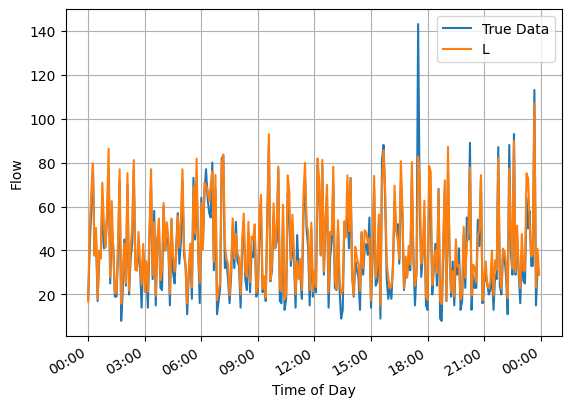

In [ ]:
plot_results(y_test[: 288], y_preds, name)

# predict tương lai

In [ ]:
def forecast_future(model, data_scaled, scaler, seq_len, n_steps):
    """
    model       : mô hình Keras đã huấn luyện
    data_scaled : toàn bộ chuỗi dữ liệu đã được scaler.transform, 1-D array
    scaler      : scaler dùng để scale data (MinMaxScaler hoặc StandardScaler)
    seq_len     : độ dài cửa sổ (ví dụ 96)
    n_steps     : số bước tương lai cần dự báo
    """
    predictions = []
    recent = list(data_scaled[-seq_len:])  # chỉ lấy đúng seq_len giá trị cuối cùng

    for _ in range(n_steps):
        # reshape về input cho model: (1, seq_len, 1)
        x_input = np.array(recent[-seq_len:]).reshape(1, seq_len, 1)

        # dự báo 1 bước
        yhat = model.predict(x_input, verbose=0)

        # yhat là mảng shape (1, 1) hoặc (1, pred_len) nếu multi-step output
        # Ở đây giả sử 1 output
        recent.append(yhat[0][0])

        # chuyển về scale gốc và lưu
        inv = scaler.inverse_transform(np.array(yhat).reshape(-1, 1))
        predictions.append(inv[0][0])

    return predictions


In [ ]:

custom_objects = {
    'mse': MeanSquaredError(),
    'mape': MeanAbsolutePercentageError()
}

gru = load_model('/content/drive/MyDrive/GRU/Test/Model/gru_manual_run.h5', custom_objects=custom_objects)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

file3 = '/content/drive/MyDrive/DetectionTest/csv/vehicle_region_count.csv'
df3 = pd.read_csv(file3, encoding='utf-8').fillna(0)
attr = 'total_in_region'
scaler_full = MinMaxScaler(feature_range=(0, 1)).fit(df3[attr].values.reshape(-1, 1))
X_full_scaled = scaler_full.transform(df3[attr].values.reshape(-1, 1))

future_preds = forecast_future(
    model=gru,
    data_scaled=X_full_scaled.flatten(),
    scaler=scaler_full,
    seq_len=6,
    n_steps=24
)

print("24 bước giá trị tương lai:", future_preds)

24 bước giá trị tương lai: [np.float32(0.25143334), np.float32(0.25121188), np.float32(0.25110546), np.float32(0.25105432), np.float32(0.25103074), np.float32(0.25102052), np.float32(0.2510165), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653), np.float32(0.25101653)]
